#  RSA Cryptography and Classical Security

## An Educational Exploration of Public-Key Cryptography

---

### [!] EDUCATIONAL DISCLAIMER

> **WARNING: This notebook is for EDUCATIONAL PURPOSES ONLY.**
>
> The implementations in this notebook are:
> - **NOT cryptographically secure** — do not use in production
> - **NOT constant-time** — vulnerable to timing side-channel attacks
> - **Simplified for pedagogy** — real RSA libraries have many additional safeguards
>
> For production cryptography, use established libraries such as:
> - `cryptography` (Python)
> - OpenSSL
> - libsodium

---

###  Learning Objectives

By the end of this notebook, you will understand:

1. The mathematical foundations of RSA (modular arithmetic, Euler's theorem)
2. How RSA key generation, encryption, and decryption work
3. Why RSA security relies on the hardness of integer factorization
4. How classical attacks (trial division, Pollard's rho) work on small keys
5. Why large key sizes (2048+ bits) are computationally infeasible to attack classically

---

## Part 1: Mathematical Foundations of RSA

### 1.1 The RSA Problem

RSA security is based on a simple asymmetry:

| Operation | Complexity | Practical |
|-----------|------------|----------|
| **Multiply** two primes $p \times q = N$ | $O(n^2)$ or better | Very fast |
| **Factor** $N$ back to $p$ and $q$ | Sub-exponential | Very slow for large $N$ |

This asymmetry is the **trapdoor function** that makes RSA possible.

### 1.2 Key Mathematical Concepts

#### Euler's Totient Function

For $N = p \cdot q$ where $p, q$ are distinct primes:

$$\phi(N) = (p - 1)(q - 1)$$

This counts the integers from $1$ to $N-1$ that are coprime to $N$.

#### Euler's Theorem

For any integer $a$ coprime to $N$:

$$a^{\phi(N)} \equiv 1 \pmod{N}$$

#### The RSA Identity

If we choose $e$ and $d$ such that:

$$e \cdot d \equiv 1 \pmod{\phi(N)}$$

Then for any message $m$ where $0 < m < N$:

$$\left(m^e\right)^d \equiv m^{ed} \equiv m \pmod{N}$$

This is the mathematical foundation of RSA encryption and decryption.

### 1.3 RSA Key Components

| Component | Symbol | Description | Public/Private |
|-----------|--------|-------------|-----------------|
| Modulus | $N$ | Product of two primes: $N = p \cdot q$ | **Public** |
| Public exponent | $e$ | Typically 65537 ($2^{16} + 1$) | **Public** |
| Private exponent | $d$ | Satisfies $ed \equiv 1 \pmod{\phi(N)}$ | **Private** |
| Prime factors | $p, q$ | Large prime numbers | **Private** |

**Public Key:** $(N, e)$

**Private Key:** $(N, d)$ — or equivalently, knowledge of $p$ and $q$

---

## Part 2: RSA Implementation

Let's implement RSA step by step. First, we need some helper functions.

In [1]:
# Import required libraries
import random
import time
import math
from typing import Tuple, Optional
import matplotlib.pyplot as plt

# Set up inline plotting
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')

print("[OK] Libraries imported successfully")

[OK] Libraries imported successfully


### 2.1 Mathematical Helper Functions

#### Greatest Common Divisor (GCD)

We use the Euclidean algorithm:

$$\gcd(a, b) = \gcd(b, a \mod b)$$

#### Extended Euclidean Algorithm

Finds $x, y$ such that:

$$ax + by = \gcd(a, b)$$

This is used to compute the modular multiplicative inverse.

In [2]:
def gcd(a: int, b: int) -> int:
    """
    Compute the Greatest Common Divisor using Euclidean algorithm.
    
    Mathematical basis: gcd(a, b) = gcd(b, a mod b)
    Time complexity: O(log(min(a, b)))
    """
    while b:
        a, b = b, a % b
    return a


def extended_gcd(a: int, b: int) -> Tuple[int, int, int]:
    """
    Extended Euclidean Algorithm.
    
    Returns (gcd, x, y) such that: a*x + b*y = gcd(a, b)
    
    This is essential for computing modular multiplicative inverses.
    """
    if a == 0:
        return b, 0, 1
    
    gcd_val, x1, y1 = extended_gcd(b % a, a)
    
    # Update x and y using results of recursive call
    x = y1 - (b // a) * x1
    y = x1
    
    return gcd_val, x, y


def mod_inverse(e: int, phi: int) -> int:
    """
    Compute modular multiplicative inverse of e modulo phi.
    
    Finds d such that: e * d ≡ 1 (mod phi)
    
    This is the core of RSA private key derivation.
    """
    gcd_val, x, _ = extended_gcd(e, phi)
    
    if gcd_val != 1:
        raise ValueError(f"Modular inverse does not exist: gcd({e}, {phi}) = {gcd_val} ≠ 1")
    
    return x % phi


# Demonstration
print("=" * 60)
print("MATHEMATICAL HELPER FUNCTIONS DEMO")
print("=" * 60)

print(f"\ngcd(48, 18) = {gcd(48, 18)}")
print(f"gcd(17, 3120) = {gcd(17, 3120)}  ← Should be 1 (coprime)")

# Verify modular inverse
e, phi = 17, 3120
d = mod_inverse(e, phi)
print(f"\nModular inverse of {e} mod {phi}:")
print(f"d = {d}")
print(f"Verification: {e} × {d} mod {phi} = {(e * d) % phi}  [OK]")

MATHEMATICAL HELPER FUNCTIONS DEMO

gcd(48, 18) = 6
gcd(17, 3120) = 1  ← Should be 1 (coprime)

Modular inverse of 17 mod 3120:
d = 2753
Verification: 17 × 2753 mod 3120 = 1  [OK]


### 2.2 Prime Number Generation

For RSA, we need large prime numbers. We use the **Miller-Rabin primality test**, which is probabilistic but highly reliable.

The probability of a composite number passing $k$ rounds of Miller-Rabin is at most $4^{-k}$.

For $k = 40$ rounds: probability of error $< 10^{-24}$

In [3]:
def is_prime_miller_rabin(n: int, k: int = 40) -> bool:
    """
    Miller-Rabin primality test.
    
    Args:
        n: Number to test for primality
        k: Number of rounds (higher = more accurate)
    
    Returns:
        True if n is probably prime, False if definitely composite
    
    Note: This is probabilistic. For k=40, error probability < 10^-24
    """
    if n < 2:
        return False
    if n == 2 or n == 3:
        return True
    if n % 2 == 0:
        return False
    
    # Write n-1 as 2^r * d where d is odd
    r, d = 0, n - 1
    while d % 2 == 0:
        r += 1
        d //= 2
    
    # Witness loop
    for _ in range(k):
        a = random.randrange(2, n - 1)
        x = pow(a, d, n)  # a^d mod n
        
        if x == 1 or x == n - 1:
            continue
        
        for _ in range(r - 1):
            x = pow(x, 2, n)
            if x == n - 1:
                break
        else:
            return False  # Composite
    
    return True  # Probably prime


def generate_prime(bits: int) -> int:
    """
    Generate a random prime number with specified bit length.
    
    Uses rejection sampling: generate random odd numbers until
    we find one that passes Miller-Rabin.
    
    Expected attempts: O(bits) by Prime Number Theorem
    """
    while True:
        # Generate random odd number with exactly 'bits' bits
        candidate = random.getrandbits(bits)
        candidate |= (1 << bits - 1) | 1  # Ensure MSB=1 and LSB=1 (odd)
        
        if is_prime_miller_rabin(candidate):
            return candidate


# Demonstration
print("=" * 60)
print("PRIME GENERATION DEMO")
print("=" * 60)

print(f"\nPrimality tests:")
test_numbers = [17, 18, 997, 1000, 104729]
for n in test_numbers:
    result = "Prime" if is_prime_miller_rabin(n) else "Composite"
    print(f"  {n}: {result}")

print(f"\nGenerating random primes:")
for bits in [16, 32, 64]:
    p = generate_prime(bits)
    print(f"  {bits}-bit prime: {p}")

PRIME GENERATION DEMO

Primality tests:
  17: Prime
  18: Composite
  997: Prime
  1000: Composite
  104729: Prime

Generating random primes:
  16-bit prime: 54361
  32-bit prime: 3214327499
  64-bit prime: 9908196694698785201


### 2.3 RSA Key Generation

The RSA key generation algorithm:

1. Choose two distinct large primes $p$ and $q$
2. Compute $N = p \cdot q$
3. Compute $\phi(N) = (p-1)(q-1)$
4. Choose $e$ such that $1 < e < \phi(N)$ and $\gcd(e, \phi(N)) = 1$
5. Compute $d \equiv e^{-1} \pmod{\phi(N)}$

**Public Key:** $(N, e)$

**Private Key:** $(N, d)$

In [4]:
class RSA:
    """
    Educational RSA implementation.
    
    [!] WARNING: This is NOT secure for production use!
    - Not constant-time (vulnerable to timing attacks)
    - No padding (vulnerable to various attacks)
    - Small key sizes for demonstration
    """
    
    def __init__(self, key_size: int = 512):
        """
        Initialize RSA with specified key size.
        
        Args:
            key_size: Bit length of modulus N (p and q will be key_size/2 bits each)
        
         INTERACTIVE: Try changing key_size to see how it affects security!
            - 64 bits: Trivially breakable (seconds)
            - 128 bits: Breakable with effort (minutes-hours)
            - 512 bits: Difficult but feasible for attackers
            - 2048 bits: Current minimum standard
        """
        self.key_size = key_size
        self.p = None
        self.q = None
        self.N = None
        self.e = None
        self.d = None
        self.phi = None
    
    def generate_keys(self) -> Tuple[Tuple[int, int], Tuple[int, int]]:
        """
        Generate RSA key pair.
        
        Returns:
            (public_key, private_key) where:
            - public_key = (N, e)
            - private_key = (N, d)
        """
        print(f"\n{'='*60}")
        print(f"RSA KEY GENERATION ({self.key_size}-bit modulus)")
        print(f"{'='*60}")
        
        # Step 1: Generate two distinct primes
        prime_bits = self.key_size // 2
        print(f"\n[Step 1] Generating two {prime_bits}-bit primes...")
        
        self.p = generate_prime(prime_bits)
        self.q = generate_prime(prime_bits)
        
        # Ensure p ≠ q
        while self.p == self.q:
            self.q = generate_prime(prime_bits)
        
        print(f"    p = {self.p}")
        print(f"    q = {self.q}")
        
        # Step 2: Compute N = p × q
        self.N = self.p * self.q
        print(f"\n[Step 2] Computing N = p × q")
        print(f"    N = {self.N}")
        print(f"    N has {self.N.bit_length()} bits")
        
        # Step 3: Compute φ(N) = (p-1)(q-1)
        self.phi = (self.p - 1) * (self.q - 1)
        print(f"\n[Step 3] Computing φ(N) = (p-1)(q-1)")
        print(f"    φ(N) = {self.phi}")
        
        # Step 4: Choose e (typically 65537)
        self.e = 65537  # Fermat prime F4 = 2^16 + 1
        print(f"\n[Step 4] Choosing public exponent e")
        print(f"    e = {self.e} (standard choice: 2¹⁶ + 1)")
        print(f"    gcd(e, φ(N)) = {gcd(self.e, self.phi)}")
        
        # Step 5: Compute d = e^(-1) mod φ(N)
        self.d = mod_inverse(self.e, self.phi)
        print(f"\n[Step 5] Computing private exponent d = e⁻¹ mod φ(N)")
        print(f"    d = {self.d}")
        print(f"    Verification: e × d mod φ(N) = {(self.e * self.d) % self.phi}")
        
        # Summary
        print(f"\n{'='*60}")
        print("KEY GENERATION COMPLETE")
        print(f"{'='*60}")
        print(f"\n[OPEN] Public Key (N, e):")
        print(f"    N = {self.N}")
        print(f"    e = {self.e}")
        print(f"\n Private Key (N, d):")
        print(f"    d = {self.d}")
        print(f"\n[!]  Keep secret: p = {self.p}, q = {self.q}")
        
        return (self.N, self.e), (self.N, self.d)
    
    def encrypt(self, message: int) -> int:
        """
        Encrypt a message using the public key.
        
        Mathematical operation:
            c ≡ m^e (mod N)
        
        Args:
            message: Integer message where 0 < m < N
        
        Returns:
            Ciphertext c
        """
        if message >= self.N:
            raise ValueError(f"Message {message} must be less than N = {self.N}")
        
        ciphertext = pow(message, self.e, self.N)
        return ciphertext
    
    def decrypt(self, ciphertext: int) -> int:
        """
        Decrypt a ciphertext using the private key.
        
        Mathematical operation:
            m ≡ c^d (mod N)
        
        Args:
            ciphertext: Encrypted message
        
        Returns:
            Original message m
        """
        message = pow(ciphertext, self.d, self.N)
        return message

### 2.4 RSA Encryption and Decryption Demo

Let's see RSA in action!

**Encryption:** $c \equiv m^e \pmod{N}$

**Decryption:** $m \equiv c^d \pmod{N}$

---

 **INTERACTIVE:** You can modify the `message` variable below to encrypt different values!

In [5]:
# =============================================================================
# RSA ENCRYPTION/DECRYPTION DEMONSTRATION
# =============================================================================

#  INTERACTIVE: Try changing this key size!
# Smaller = faster but less secure, Larger = slower but more secure
KEY_SIZE = 512  # Try: 64, 128, 256, 512, 1024

# Initialize RSA
rsa = RSA(key_size=KEY_SIZE)
public_key, private_key = rsa.generate_keys()

print("\n" + "="*60)
print("ENCRYPTION / DECRYPTION TEST")
print("="*60)

#  INTERACTIVE: Change this message!
message = 42  # Try different values (must be < N)

print(f"\nOriginal message: m = {message}")

# Encrypt
ciphertext = rsa.encrypt(message)
print(f"\nEncryption: c = m^e mod N")
print(f"           c = {message}^{rsa.e} mod {rsa.N}")
print(f"           c = {ciphertext}")

# Decrypt
decrypted = rsa.decrypt(ciphertext)
print(f"\nDecryption: m = c^d mod N")
print(f"           m = {ciphertext}^{rsa.d} mod {rsa.N}")
print(f"           m = {decrypted}")

# Verify
print(f"\n{'[OK] SUCCESS!' if message == decrypted else '[X] FAILED!'} Original = Decrypted: {message == decrypted}")


RSA KEY GENERATION (512-bit modulus)

[Step 1] Generating two 256-bit primes...
    p = 109159831572832182871167292810390076526258391218999376423850642088234890035931
    q = 108345475095570931852337465039313203436822863405747129749963310576725182769471

[Step 2] Computing N = p × q
    N = 11826973813111006772723264294671677291741624487735638460459221398126145910987303820480575174949777132298649391394601861887100156322736124608481585279862501
    N has 512 bits

[Step 3] Computing φ(N) = (p-1)(q-1)
    φ(N) = 11826973813111006772723264294671677291741624487735638460459221398126145910987086315173906771835053627540799688114638780632475409816562310655816625207057100

[Step 4] Choosing public exponent e
    e = 65537 (standard choice: 2¹⁶ + 1)
    gcd(e, φ(N)) = 1

[Step 5] Computing private exponent d = e⁻¹ mod φ(N)
    d = 5369843489676535659690761743019217075744446316692275478423250864742688828102167331344351586168482776768909707791616820368645777110664633960579207160248273
    Verific

### 2.5 Encrypting Text Messages

Real-world RSA converts text to numbers. Here's a simple demonstration:

In [6]:
def text_to_int(text: str) -> int:
    """Convert text to integer (simple encoding)."""
    return int.from_bytes(text.encode('utf-8'), 'big')

def int_to_text(number: int) -> str:
    """Convert integer back to text."""
    byte_length = (number.bit_length() + 7) // 8
    return number.to_bytes(byte_length, 'big').decode('utf-8')

# Demo with text
print("="*60)
print("TEXT ENCRYPTION DEMO")
print("="*60)

#  INTERACTIVE: Try your own message!
secret_message = "Hello!"  # Keep it short for small key sizes

print(f"\nOriginal text: '{secret_message}'")

# Convert to number
message_int = text_to_int(secret_message)
print(f"As integer: {message_int}")

# Check if message fits
if message_int < rsa.N:
    # Encrypt
    encrypted = rsa.encrypt(message_int)
    print(f"Encrypted: {encrypted}")
    
    # Decrypt
    decrypted_int = rsa.decrypt(encrypted)
    decrypted_text = int_to_text(decrypted_int)
    print(f"Decrypted: '{decrypted_text}'")
    
    print(f"\n{'[OK] SUCCESS!' if secret_message == decrypted_text else '[X] FAILED!'}")
else:
    print(f"\n[!] Message too long for this key size. Use a larger key or shorter message.")

TEXT ENCRYPTION DEMO

Original text: 'Hello!'
As integer: 79600447942433
Encrypted: 2733847413428613227498427242730457317695578646116762658204078709071379485662730768431217661744189411423680863701793153216193508162144015378322728707994962
Decrypted: 'Hello!'

[OK] SUCCESS!


---

## Part 3: Classical Attacks on RSA

### 3.1 The Core Insight

RSA security depends entirely on the difficulty of factoring $N = p \times q$.

If an attacker can factor $N$, they can:
1. Compute $\phi(N) = (p-1)(q-1)$
2. Compute $d = e^{-1} \mod \phi(N)$
3. Decrypt any message!

Let's explore classical factorization attacks.

### 3.2 Attack 1: Trial Division

The simplest factorization method: try all possible divisors up to $\sqrt{N}$.

**Complexity:** $O(\sqrt{N}) = O(2^{n/2})$ where $n$ = bit length of $N$

This is **exponential** in the bit length — but manageable for small $N$.

In [7]:
def trial_division(N: int, verbose: bool = True) -> Optional[Tuple[int, int]]:
    """
    Factor N using trial division.
    
    Try all possible divisors from 2 to √N.
    
    Complexity: O(√N) = O(2^(n/2)) where n = bit length
    
    This is the simplest but slowest factorization method.
    """
    if verbose:
        print(f"\nAttempting trial division on N = {N}")
        print(f"N has {N.bit_length()} bits")
        print(f"Will try divisors up to √N ≈ {int(N**0.5)}")
    
    start_time = time.time()
    attempts = 0
    
    # Check 2 first
    if N % 2 == 0:
        return 2, N // 2
    
    # Try odd numbers from 3 to √N
    limit = int(N**0.5) + 1
    for i in range(3, limit, 2):
        attempts += 1
        
        if N % i == 0:
            elapsed = time.time() - start_time
            if verbose:
                print(f"\n[OK] FACTORED! N = {i} × {N // i}")
                print(f"   Attempts: {attempts:,}")
                print(f"   Time: {elapsed:.4f} seconds")
            return i, N // i
        
        # Progress indicator
        if verbose and attempts % 1000000 == 0:
            elapsed = time.time() - start_time
            progress = (i / limit) * 100
            print(f"   Progress: {progress:.1f}%, Attempts: {attempts:,}, Time: {elapsed:.1f}s")
    
    if verbose:
        print(f"\n[X] Failed to factor (N may be prime)")
    return None


# Demo: Attack a small RSA key
print("="*60)
print("TRIAL DIVISION ATTACK DEMO")
print("="*60)

# Generate a small key to attack
#  INTERACTIVE: Try different bit sizes!
ATTACK_KEY_SIZE = 32  # Try: 24, 32, 40, 48 (larger = much slower)

print(f"\nGenerating {ATTACK_KEY_SIZE}-bit RSA key to attack...")
victim_rsa = RSA(key_size=ATTACK_KEY_SIZE)
victim_rsa.generate_keys()

print(f"\n" + "-"*60)
print("ATTACKER'S VIEW (only knows N and e)")
print("-"*60)
print(f"N = {victim_rsa.N}")
print(f"e = {victim_rsa.e}")

print(f"\n" + "-"*60)
print("LAUNCHING TRIAL DIVISION ATTACK...")
print("-"*60)

result = trial_division(victim_rsa.N)

if result:
    p_found, q_found = result
    
    # Verify we found the correct factors
    print(f"\nVerification:")
    print(f"   Actual p = {victim_rsa.p}")
    print(f"   Actual q = {victim_rsa.q}")
    print(f"   Found factors match: {set([p_found, q_found]) == set([victim_rsa.p, victim_rsa.q])}")

TRIAL DIVISION ATTACK DEMO

Generating 32-bit RSA key to attack...

RSA KEY GENERATION (32-bit modulus)

[Step 1] Generating two 16-bit primes...
    p = 63599
    q = 57349

[Step 2] Computing N = p × q
    N = 3647339051
    N has 32 bits

[Step 3] Computing φ(N) = (p-1)(q-1)
    φ(N) = 3647218104

[Step 4] Choosing public exponent e
    e = 65537 (standard choice: 2¹⁶ + 1)
    gcd(e, φ(N)) = 1

[Step 5] Computing private exponent d = e⁻¹ mod φ(N)
    d = 2529239489
    Verification: e × d mod φ(N) = 1

KEY GENERATION COMPLETE

[OPEN] Public Key (N, e):
    N = 3647339051
    e = 65537

 Private Key (N, d):
    d = 2529239489

[!]  Keep secret: p = 63599, q = 57349

------------------------------------------------------------
ATTACKER'S VIEW (only knows N and e)
------------------------------------------------------------
N = 3647339051
e = 65537

------------------------------------------------------------
LAUNCHING TRIAL DIVISION ATTACK...
------------------------------------------

### 3.3 Attack 2: Pollard's Rho Algorithm

A more sophisticated factorization method using cycle detection.

**Idea:** Use a pseudo-random sequence $x_{n+1} = f(x_n) \mod N$ and detect when two values become equal modulo a factor of $N$.

**Complexity:** $O(N^{1/4})$ expected — much better than trial division!

The function commonly used is:
$$f(x) = x^2 + c \pmod{N}$$

In [8]:
def pollard_rho(N: int, max_iterations: int = 1000000, verbose: bool = True) -> Optional[Tuple[int, int]]:
    """
    Factor N using Pollard's Rho algorithm.
    
    Uses Floyd's cycle detection with f(x) = x² + 1 mod N.
    
    Expected complexity: O(N^(1/4))
    
    Much faster than trial division for balanced semiprimes!
    """
    if verbose:
        print(f"\nAttempting Pollard's Rho on N = {N}")
        print(f"N has {N.bit_length()} bits")
    
    start_time = time.time()
    
    # Check for even N
    if N % 2 == 0:
        return 2, N // 2
    
    # Initialize
    x = random.randint(2, N - 1)
    y = x
    c = random.randint(1, N - 1)
    d = 1
    
    # f(x) = x² + c mod N
    f = lambda x: (x * x + c) % N
    
    iterations = 0
    while d == 1 and iterations < max_iterations:
        # Tortoise moves one step
        x = f(x)
        
        # Hare moves two steps
        y = f(f(y))
        
        # Check for factor
        d = gcd(abs(x - y), N)
        iterations += 1
        
        if verbose and iterations % 100000 == 0:
            print(f"   Iterations: {iterations:,}")
    
    elapsed = time.time() - start_time
    
    if d != 1 and d != N:
        if verbose:
            print(f"\n[OK] FACTORED! N = {d} × {N // d}")
            print(f"   Iterations: {iterations:,}")
            print(f"   Time: {elapsed:.4f} seconds")
        return d, N // d
    
    if verbose:
        print(f"\n[X] Failed after {iterations:,} iterations")
    return None


# Demo: Compare with trial division
print("="*60)
print("POLLARD'S RHO vs TRIAL DIVISION")
print("="*60)

# Generate a larger key
#  INTERACTIVE: Try different sizes!
ATTACK_KEY_SIZE = 48  # Try: 40, 48, 56, 64

print(f"\nGenerating {ATTACK_KEY_SIZE}-bit RSA key...")
victim_rsa = RSA(key_size=ATTACK_KEY_SIZE)
victim_rsa.generate_keys()

N = victim_rsa.N
print(f"\nTarget N = {N}")

print(f"\n--- Pollard's Rho ---")
start = time.time()
result_rho = pollard_rho(N, verbose=False)
rho_time = time.time() - start
print(f"Result: {result_rho}")
print(f"Time: {rho_time:.6f} seconds")

print(f"\n--- Trial Division ---")
start = time.time()
result_trial = trial_division(N, verbose=False)
trial_time = time.time() - start
print(f"Result: {result_trial}")
print(f"Time: {trial_time:.6f} seconds")

if rho_time > 0:
    print(f"\n Pollard's Rho was {trial_time/rho_time:.1f}x faster!")

POLLARD'S RHO vs TRIAL DIVISION

Generating 48-bit RSA key...

RSA KEY GENERATION (48-bit modulus)

[Step 1] Generating two 24-bit primes...
    p = 16067761
    q = 11639813

[Step 2] Computing N = p × q
    N = 187025733368693
    N has 48 bits

[Step 3] Computing φ(N) = (p-1)(q-1)
    φ(N) = 187025705661120

[Step 4] Choosing public exponent e
    e = 65537 (standard choice: 2¹⁶ + 1)
    gcd(e, φ(N)) = 1

[Step 5] Computing private exponent d = e⁻¹ mod φ(N)
    d = 100314747476993
    Verification: e × d mod φ(N) = 1

KEY GENERATION COMPLETE

[OPEN] Public Key (N, e):
    N = 187025733368693
    e = 65537

 Private Key (N, d):
    d = 100314747476993

[!]  Keep secret: p = 16067761, q = 11639813

Target N = 187025733368693

--- Pollard's Rho ---
Result: (11639813, 16067761)
Time: 0.001850 seconds

--- Trial Division ---


Result: (11639813, 16067761)
Time: 0.385544 seconds

 Pollard's Rho was 208.4x faster!


---

## Part 4: Scaling Analysis — Why Large Keys Are Secure

Let's visualize how factorization time grows with key size.

In [9]:
def benchmark_factorization(bit_sizes: list, num_trials: int = 3):
    """
    Benchmark factorization time across different key sizes.
    """
    results = {'bits': [], 'trial_div': [], 'pollard_rho': []}
    
    for bits in bit_sizes:
        print(f"\nBenchmarking {bits}-bit keys...")
        
        trial_times = []
        rho_times = []
        
        for trial in range(num_trials):
            # Generate RSA instance
            rsa_instance = RSA(key_size=bits)
            rsa_instance.generate_keys()
            N = rsa_instance.N
            
            # Time trial division
            start = time.time()
            trial_division(N, verbose=False)
            trial_times.append(time.time() - start)
            
            # Time Pollard's rho
            start = time.time()
            pollard_rho(N, verbose=False)
            rho_times.append(time.time() - start)
        
        results['bits'].append(bits)
        results['trial_div'].append(sum(trial_times) / num_trials)
        results['pollard_rho'].append(sum(rho_times) / num_trials)
        
        print(f"   Trial Division: {results['trial_div'][-1]:.6f}s avg")
        print(f"   Pollard's Rho:  {results['pollard_rho'][-1]:.6f}s avg")
    
    return results


# Run benchmark
#  INTERACTIVE: Adjust bit sizes (larger = much slower!)
BIT_SIZES = [24, 28, 32, 36, 40, 44]

print("="*60)
print("FACTORIZATION SCALING BENCHMARK")
print("="*60)
print(f"Testing key sizes: {BIT_SIZES}")
print("[!] This may take a minute...")

benchmark_results = benchmark_factorization(BIT_SIZES, num_trials=2)

FACTORIZATION SCALING BENCHMARK
Testing key sizes: [24, 28, 32, 36, 40, 44]
[!] This may take a minute...

Benchmarking 24-bit keys...

RSA KEY GENERATION (24-bit modulus)

[Step 1] Generating two 12-bit primes...
    p = 2459
    q = 2333

[Step 2] Computing N = p × q
    N = 5736847
    N has 23 bits

[Step 3] Computing φ(N) = (p-1)(q-1)
    φ(N) = 5732056

[Step 4] Choosing public exponent e
    e = 65537 (standard choice: 2¹⁶ + 1)
    gcd(e, φ(N)) = 1

[Step 5] Computing private exponent d = e⁻¹ mod φ(N)
    d = 2626161
    Verification: e × d mod φ(N) = 1

KEY GENERATION COMPLETE

[OPEN] Public Key (N, e):
    N = 5736847
    e = 65537

 Private Key (N, d):
    d = 2626161

[!]  Keep secret: p = 2459, q = 2333

RSA KEY GENERATION (24-bit modulus)

[Step 1] Generating two 12-bit primes...
    p = 2963
    q = 2213

[Step 2] Computing N = p × q
    N = 6557119
    N has 23 bits

[Step 3] Computing φ(N) = (p-1)(q-1)
    φ(N) = 6551944

[Step 4] Choosing public exponent e
    e = 6553

   Trial Division: 0.103768s avg
   Pollard's Rho:  0.003159s avg


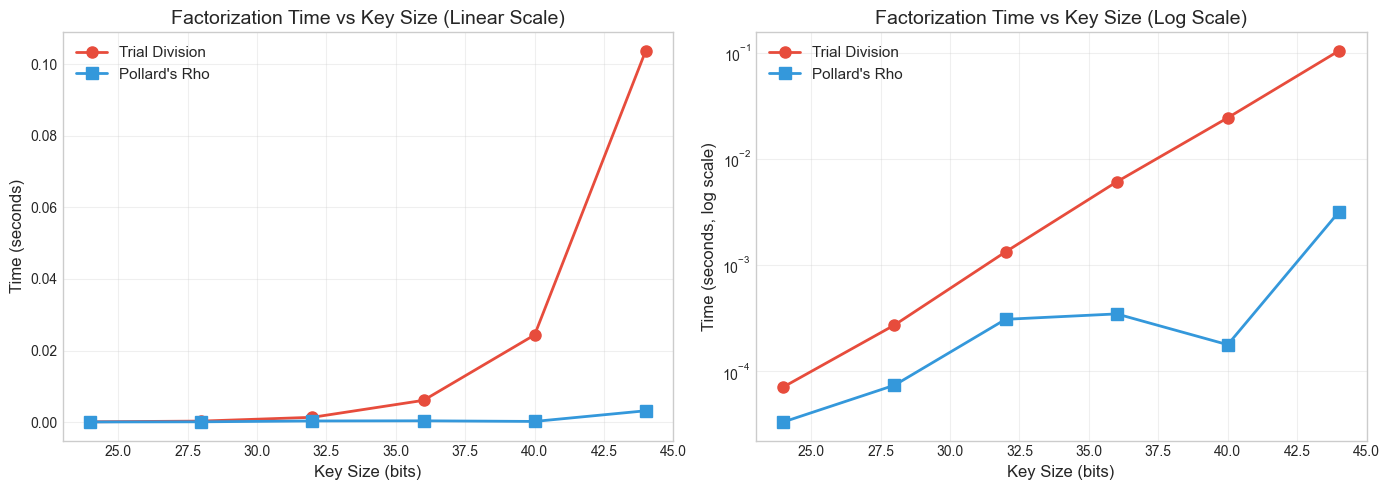


KEY INSIGHT

Notice how factorization time grows EXPONENTIALLY with key size!

Extrapolating to RSA-2048:
• Trial Division: Would take longer than the age of the universe
• Best classical algorithms (GNFS): Still computationally infeasible

This exponential growth is WHY RSA is secure — at sufficient key sizes.



In [10]:
# Visualize the results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Linear scale
ax1 = axes[0]
ax1.plot(benchmark_results['bits'], benchmark_results['trial_div'], 
         'o-', label='Trial Division', linewidth=2, markersize=8, color='#e74c3c')
ax1.plot(benchmark_results['bits'], benchmark_results['pollard_rho'], 
         's-', label="Pollard's Rho", linewidth=2, markersize=8, color='#3498db')
ax1.set_xlabel('Key Size (bits)', fontsize=12)
ax1.set_ylabel('Time (seconds)', fontsize=12)
ax1.set_title('Factorization Time vs Key Size (Linear Scale)', fontsize=14)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Log scale
ax2 = axes[1]
ax2.semilogy(benchmark_results['bits'], benchmark_results['trial_div'], 
             'o-', label='Trial Division', linewidth=2, markersize=8, color='#e74c3c')
ax2.semilogy(benchmark_results['bits'], benchmark_results['pollard_rho'], 
             's-', label="Pollard's Rho", linewidth=2, markersize=8, color='#3498db')
ax2.set_xlabel('Key Size (bits)', fontsize=12)
ax2.set_ylabel('Time (seconds, log scale)', fontsize=12)
ax2.set_title('Factorization Time vs Key Size (Log Scale)', fontsize=14)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("KEY INSIGHT")
print("="*60)
print("""
Notice how factorization time grows EXPONENTIALLY with key size!

Extrapolating to RSA-2048:
• Trial Division: Would take longer than the age of the universe
• Best classical algorithms (GNFS): Still computationally infeasible

This exponential growth is WHY RSA is secure — at sufficient key sizes.
""")

---

## Part 5: Discussion and Key Takeaways

### 5.1 Classical Security Summary

| Attack Method | Complexity | RSA-2048 Status |
|---------------|------------|------------------|
| Trial Division | $O(\sqrt{N}) = O(2^{n/2})$ | Completely infeasible |
| Pollard's Rho | $O(N^{1/4}) = O(2^{n/4})$ | Infeasible |
| Quadratic Sieve | $L_N[1/2, 1]$ | Infeasible |
| General Number Field Sieve (GNFS) | $L_N[1/3, c]$ | Best known, still infeasible |

where $L_N[\alpha, c] = \exp\left(c \cdot (\ln N)^\alpha (\ln \ln N)^{1-\alpha}\right)$

### 5.2 Why 2048 Bits?

NIST recommendations:
- **1024 bits**: Deprecated (no longer considered secure)
- **2048 bits**: Minimum recommended until 2030
- **3072 bits**: Recommended for security beyond 2030
- **4096 bits**: Maximum common size (diminishing returns)

### 5.3 The Quantum Threat (Preview)

> **Coming in Notebook 02...**
>
> Shor's Algorithm can factor $N$ in **polynomial time** $O(n^2 \log n \log \log n)$, 
> breaking the exponential barrier that protects RSA.
>
> However, this requires a **fault-tolerant quantum computer** with thousands of 
> logical qubits — technology that does not yet exist.

### 5.4 What We Learned

1. [OK] RSA security relies on the hardness of integer factorization
2. [OK] Classical factorization is exponential in key size
3. [OK] Small keys (< 512 bits) are trivially breakable
4. [OK] Large keys (2048+ bits) remain secure against classical computers
5. [!] Quantum computers threaten this security — topic for next notebook!

---

##  References

1. Rivest, R. L., Shamir, A., & Adleman, L. (1978). "A Method for Obtaining Digital Signatures and Public-Key Cryptosystems." *Communications of the ACM*, 21(2), 120-126.

2. Boneh, D. (1999). "Twenty Years of Attacks on the RSA Cryptosystem." *Notices of the AMS*, 46(2), 203-213.

3. Lenstra, A. K. (2000). "Integer Factoring." *Designs, Codes and Cryptography*, 19, 101-128.

4. NIST SP 800-57 Part 1 Rev. 5 (2020). "Recommendation for Key Management."

---

## --> Next Steps

Continue to **Notebook 02: Shor's Algorithm Simulation** to learn:
- How quantum computers threaten RSA
- The mathematics of quantum period finding
- Simulating Shor's algorithm with Qiskit

---

*Created for educational purposes. All code is provided under MIT License.*